In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
%matplotlib inline
import numpy as np

Function por stablishing the seed for reproducibility

In [3]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
path = Path("../datasets/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [5]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels").replace(".png",".tif"))

Aux function for splitting between training and testing

In [6]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [7]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['Tumor']

def tumour(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

{'NoTumor': 0, 'Tumor': 1}


Early Stopping parameters

In [8]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=2

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [10]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [11]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 1
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

Definition of the splitter for saying the learner what weights of the network to freeze

In [12]:
def hrnet_splitter(model):
    return [params(model.backbone), params(model.head)]

# HRNet

## Manual Annotations

In [13]:
manual_name="manual"

In [14]:
path_manual_img = path_images/manual_name
path_manual_lbl = path_labels/manual_name

../datasets/Images/manual/341.png


<AxesSubplot:>

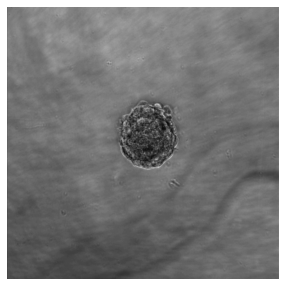

In [15]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

../datasets/Labels/manual/341.tif


<AxesSubplot:>

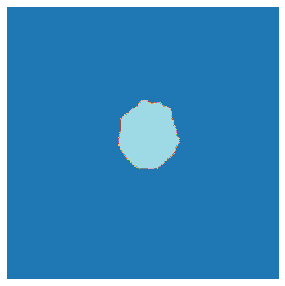

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
print(torch.max(image2tensor(mask)))

tensor(255, dtype=torch.uint8)


In [19]:
size = 1002
bs = 2

### No Data Augmentation

#### Hyper-parameter Selection

We are going to adjust weight decay.

Setting-up type transforms pipelines
Found 621 items
2 datasets of sizes 559,62
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying <lambda> gives
      ../datasets/Labels/manual/165.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'me

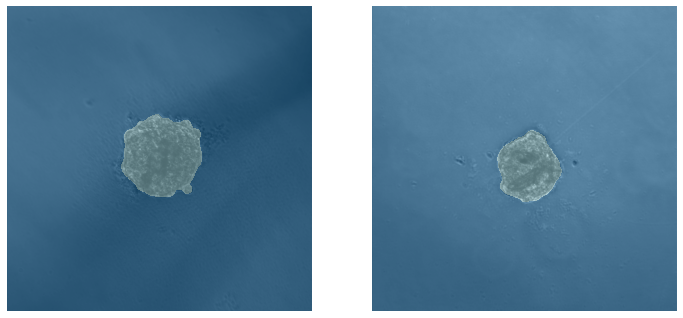

In [20]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-2

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-2,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2834: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Recorder

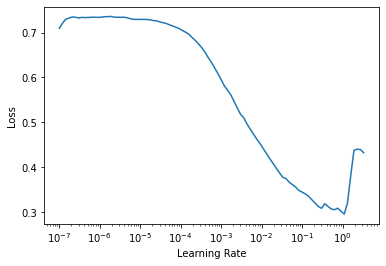

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.045365,0.025951,0.997441,0.941788,0.889980,01:58
1,0.030095,0.088035,0.962653,0.817146,0.690826,01:58
2,0.013361,0.015060,0.998133,0.965597,0.933482,01:58
3,0.010987,0.017312,0.996497,0.968819,0.939524,01:58
4,0.010385,0.014263,0.997156,0.972828,0.947094,01:59
5,0.009023,0.016398,0.996918,0.971391,0.944373,01:59
6,0.007876,0.011258,0.997718,0.974711,0.950669,01:58
7,0.007127,0.015105,0.997525,0.972972,0.947367,01:59
8,0.006913,0.014107,0.997634,0.973417,0.948211,02:02


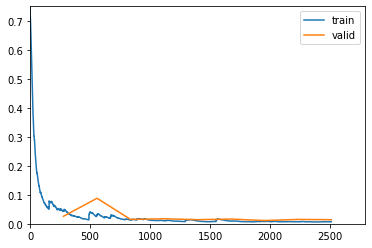

No improvement since epoch 6: early stopping


In [23]:
fname="hrnet-manual-no-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-no-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.011257709935307503,0.9977183938026428,0.9747109017036307,0.9506693315311947]

Recorder

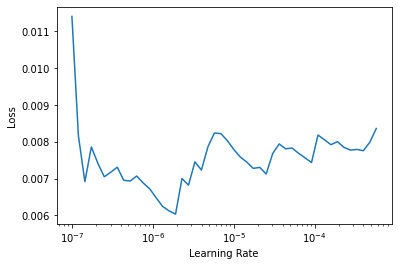

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.007938,0.011902,0.997715,0.974524,0.950314,02:59
1,0.007353,0.012252,0.997703,0.974469,0.950209,02:50
2,0.006836,0.012105,0.997929,0.973995,0.949309,02:49


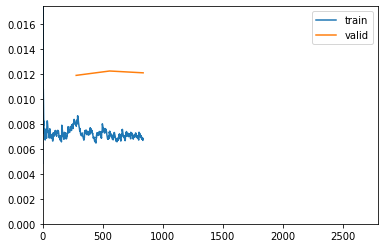

No improvement since epoch 0: early stopping


In [24]:
fname="hrnet-manual-no-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(6e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-1,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2834: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Recorder

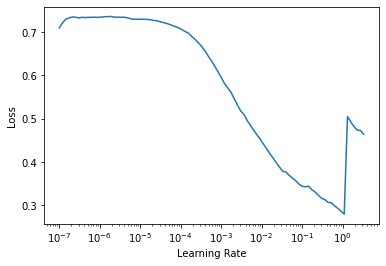

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.045232,0.025577,0.997361,0.944039,0.894009,02:02
1,0.030610,0.074622,0.967212,0.834384,0.715831,02:03
2,0.015222,0.015366,0.997118,0.967005,0.936119,02:05
3,0.011743,0.017080,0.996756,0.970510,0.942710,02:06
4,0.011208,0.016906,0.998410,0.956238,0.916146,02:05


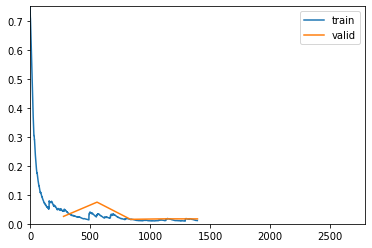

No improvement since epoch 2: early stopping


In [23]:
fname="hrnet-manual-no-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-no-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.015366299077868462,0.9971179962158203,0.9670054691385828,0.9361186727021623]

Recorder

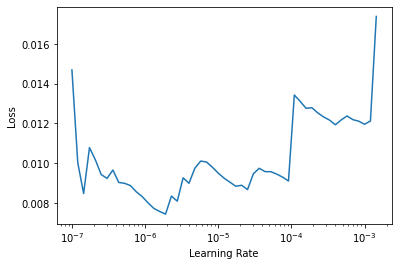

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.011105,0.014238,0.997845,0.967382,0.936824,02:48
1,0.010836,0.013161,0.997707,0.969217,0.940273,02:48
2,0.008544,0.012656,0.997873,0.969769,0.941312,02:49
3,0.009050,0.012355,0.997788,0.970612,0.942903,02:49
4,0.009224,0.012011,0.997849,0.971151,0.943919,02:49
5,0.008839,0.012552,0.997916,0.970718,0.943102,02:49
6,0.009029,0.012632,0.997917,0.970619,0.942914,02:50


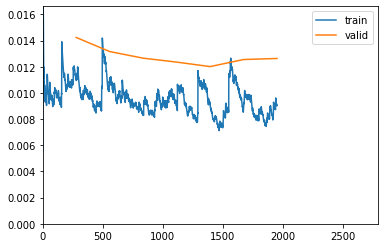

No improvement since epoch 4: early stopping


In [24]:
fname="hrnet-manual-no-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(6e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 987 items
2 datasets of sizes 621,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying <lambda> gives
      ../datasets/Labels/manual/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'m

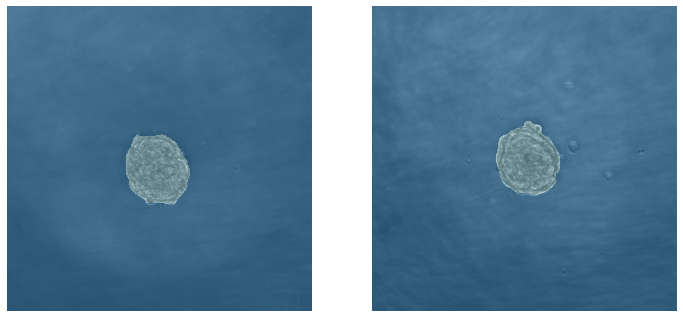

In [20]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name,test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-2,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2834: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Recorder

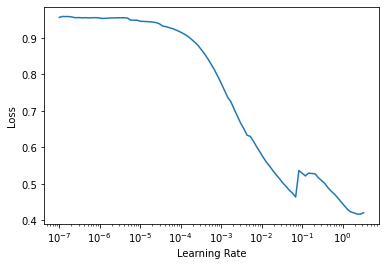

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.029312,0.090612,0.987837,0.843623,0.729539,02:26
1,0.022620,0.065047,0.980126,0.907211,0.830179,02:26
2,0.029833,0.709812,0.799134,0.541132,0.370926,02:26
3,0.008872,0.032842,0.992692,0.945648,0.896900,02:27
4,0.009830,0.058956,0.988259,0.912318,0.838773,02:26
5,0.007976,0.029196,0.996592,0.953751,0.911592,02:26
6,0.007430,0.043868,0.996079,0.940450,0.887594,02:27
7,0.006659,0.042075,0.993141,0.940511,0.887703,02:26


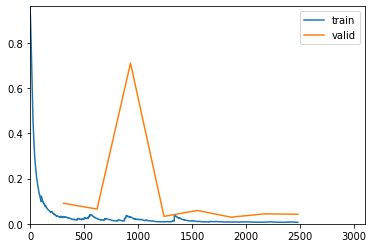

No improvement since epoch 5: early stopping


In [23]:
fname="hrnet-manual-no-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-no-data-augmentation-before-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2834: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


(#4) [0.029195817187428474,0.9965922832489014,0.9537513771843787,0.9115915246011815]

Recorder

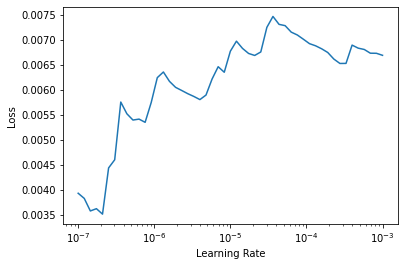

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.007432,0.033246,0.995443,0.946502,0.898437,03:21
1,0.007554,0.028568,0.996868,0.955143,0.914137,03:22
2,0.007165,0.029856,0.995631,0.951667,0.907791,03:22
3,0.006474,0.031117,0.994988,0.949579,0.903998,03:23


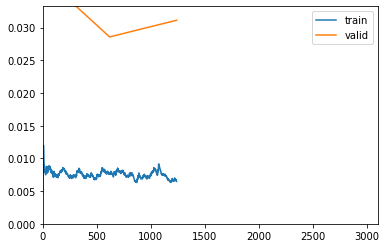

No improvement since epoch 1: early stopping


In [24]:
fname="hrnet-manual-no-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-7,2e-7),cbs=callbacksFitAfterUnfreeze)

In [22]:
learn.load("hrnet-manual-no-data-augmentation-after-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.028567679226398468,0.9968684315681458,0.95514258122377,0.9141367655143446]

In [23]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/hrnet-dataset1-no-data-augmentation.pth")

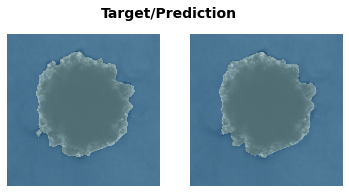

In [29]:
learn.show_results(vmin=0,vmax=1) # show results

### Data Augmentation

Setting-up type transforms pipelines
Found 621 items
2 datasets of sizes 559,62
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying <lambda> gives
      ../datasets/Labels/manual/165.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255

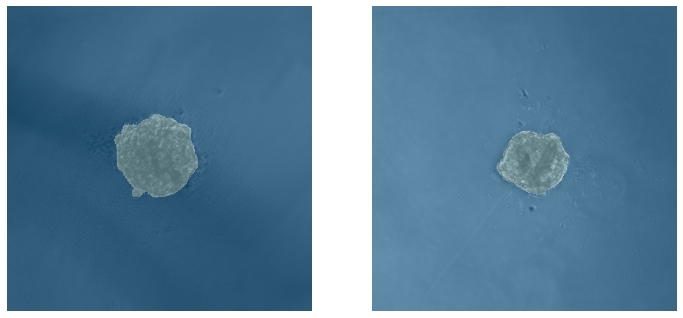

In [20]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-3

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-3,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2834: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Recorder

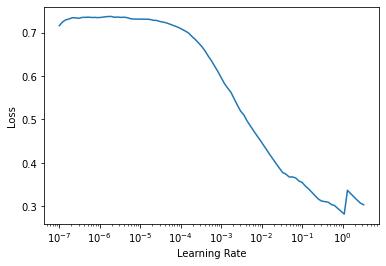

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.042789,0.024968,0.995397,0.941776,0.889959,02:01
1,0.034666,0.229532,0.926069,0.690997,0.527881,01:59
2,0.017372,0.015852,0.997396,0.961698,0.926221,01:59
3,0.014051,0.018409,0.995021,0.962223,0.927196,01:59
4,0.012773,0.011539,0.998021,0.969852,0.941469,01:59
5,0.009767,0.009010,0.997745,0.974727,0.950700,01:59
6,0.009508,0.010103,0.997362,0.973010,0.947439,01:59
7,0.008083,0.010889,0.997463,0.972840,0.947117,01:59


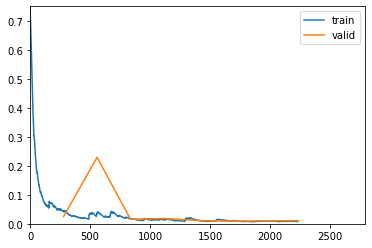

No improvement since epoch 5: early stopping


In [23]:
fname="hrnet-manual-data-augmentation-before-unfreeze-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-data-augmentation-before-unfreeze-WD-3-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.009009545668959618,0.9977453351020813,0.9747268946822969,0.9506997595340773]

Recorder

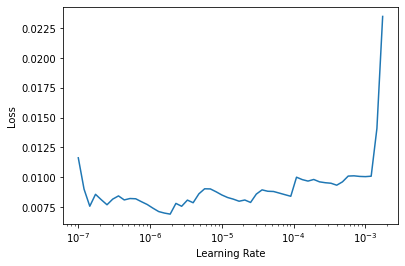

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.009642,0.009352,0.997978,0.973542,0.948448,02:48
1,0.009764,0.009280,0.998197,0.973659,0.948670,02:48
2,0.008292,0.009088,0.998473,0.974133,0.949570,02:48
3,0.008302,0.009156,0.998253,0.974452,0.950176,02:48
4,0.008507,0.008911,0.998251,0.975311,0.951812,02:48
5,0.008016,0.008868,0.998352,0.975452,0.952080,02:48
6,0.008292,0.009011,0.998372,0.974770,0.950781,02:48
7,0.008033,0.008790,0.998310,0.975788,0.952720,02:48
8,0.008709,0.008923,0.998402,0.975083,0.951377,02:48
9,0.008254,0.008756,0.998349,0.975826,0.952793,02:48


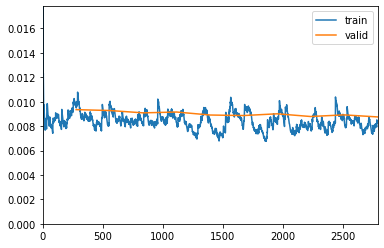

In [24]:
fname="hrnet-manual-data-augmentation-after-unfreeze-WD-3-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(6e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

WD=1e-2

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-2,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2834: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Recorder

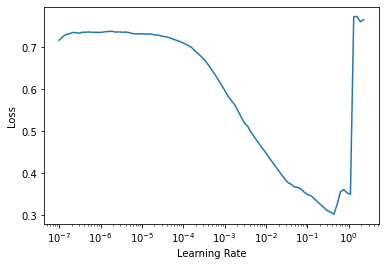

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.043441,0.026059,0.995511,0.939626,0.886126,01:59
1,0.031331,0.104388,0.967787,0.835478,0.717443,01:59
2,0.016447,0.016622,0.997844,0.961856,0.926515,01:59
3,0.013263,0.014595,0.997154,0.971573,0.944718,01:59
4,0.013144,0.010879,0.997611,0.973360,0.948103,01:59
5,0.009467,0.009807,0.997883,0.973651,0.948656,01:58
6,0.009528,0.009546,0.998432,0.976376,0.953842,01:58
7,0.008182,0.008577,0.998177,0.977412,0.955822,01:59
8,0.008215,0.008501,0.998167,0.977573,0.956129,02:00
9,0.007754,0.008496,0.998186,0.977423,0.955843,02:00


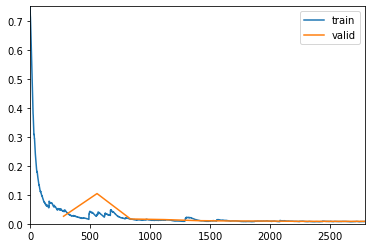

In [23]:
fname="hrnet-manual-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.008496117778122425,0.9981855154037476,0.9774228575500756,0.9558426616189888]

Recorder

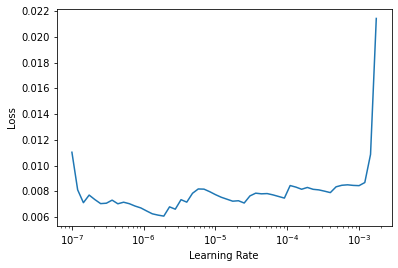

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.008331,0.008490,0.998188,0.977348,0.955700,02:48
1,0.008144,0.008493,0.998085,0.977304,0.955615,02:49
2,0.007336,0.008453,0.998276,0.977442,0.955878,02:49
3,0.007780,0.008287,0.998177,0.977697,0.956368,02:50
4,0.007609,0.008302,0.998132,0.977734,0.956438,02:49
5,0.007437,0.008395,0.998186,0.977350,0.955704,02:50


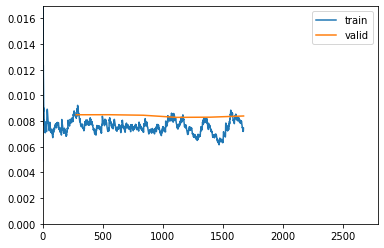

No improvement since epoch 3: early stopping


In [24]:
fname="hrnet-manual-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(6e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-1,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2834: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Recorder

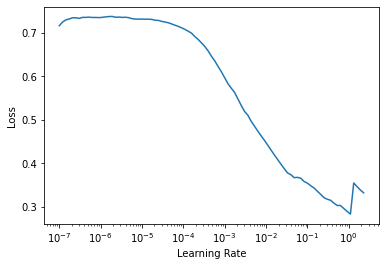

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.043024,0.025438,0.995462,0.942283,0.890866,01:59
1,0.033520,0.092063,0.972710,0.849353,0.738153,02:00
2,0.018642,0.011129,0.998371,0.970963,0.943566,02:00
3,0.012853,0.015188,0.997318,0.967561,0.937160,02:00
4,0.012717,0.011868,0.998434,0.969738,0.941253,02:00


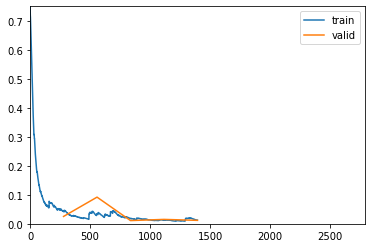

No improvement since epoch 2: early stopping


In [23]:
fname="hrnet-manual-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.011129042133688927,0.9983708262443542,0.9709634615669259,0.9435655832449091]

Recorder

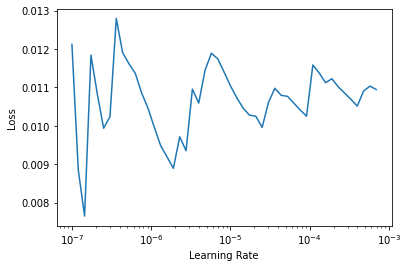

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.013606,0.011011,0.998387,0.970937,0.943515,02:48
1,0.011470,0.010523,0.998210,0.972338,0.946165,02:48
2,0.010031,0.010340,0.998527,0.972758,0.946960,02:48
3,0.010226,0.010047,0.998486,0.973352,0.948088,02:48
4,0.010296,0.010025,0.998454,0.972943,0.947312,02:48
5,0.009668,0.009879,0.998520,0.973582,0.948524,02:48
6,0.010925,0.009994,0.998538,0.973272,0.947936,02:48
7,0.009564,0.009709,0.998462,0.974202,0.949702,02:49
8,0.010196,0.009945,0.998541,0.973242,0.947878,02:50
9,0.009760,0.009747,0.998492,0.973916,0.949158,02:49


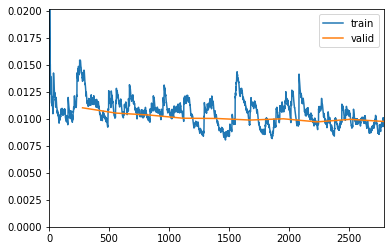

No improvement since epoch 7: early stopping


In [24]:
fname="hrnet-manual-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(6e-7,1e-6),cbs=callbacksFitAfterUnfreeze)

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 987 items
2 datasets of sizes 621,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying <lambda> gives
      ../datasets/Labels/manual/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 25

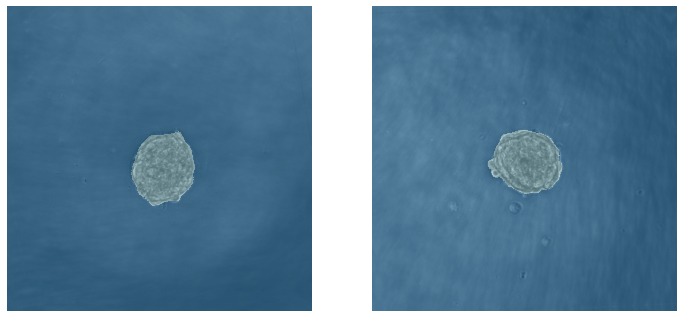

In [20]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name,test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-2,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:2834: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Recorder

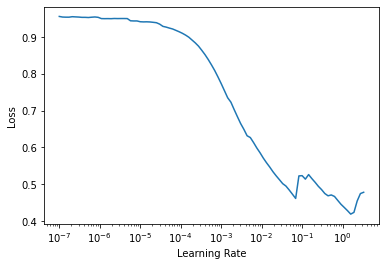

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.029608,0.085861,0.989102,0.845773,0.732761,02:27
1,0.019563,0.102489,0.993285,0.869545,0.769199,02:27
2,0.023534,0.077419,0.983725,0.924413,0.859450,02:27
3,0.009572,0.040670,0.997139,0.940441,0.887578,02:27
4,0.014001,0.037235,0.996993,0.938966,0.884953,02:27
5,0.008837,0.031156,0.998199,0.952164,0.908695,02:27
6,0.008503,0.030505,0.998313,0.957683,0.918803,02:27
7,0.006999,0.025792,0.997685,0.962723,0.928126,02:27
8,0.007203,0.027669,0.998211,0.961611,0.926061,02:27
9,0.007172,0.028127,0.998181,0.961713,0.926249,02:25


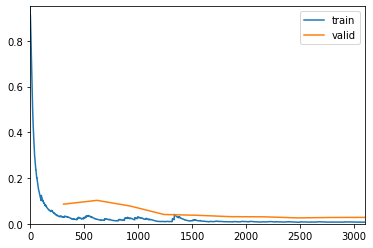

No improvement since epoch 7: early stopping


In [23]:
fname="hrnet-manual-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-data-augmentation-before-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.025792080909013748,0.997684895992279,0.9627234264716459,0.9281260668954361]

Recorder

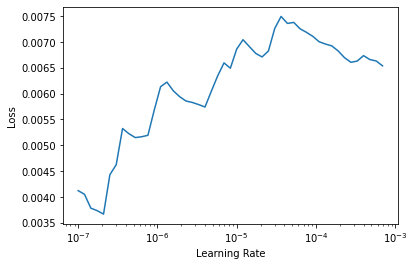

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.007888,0.025827,0.997704,0.962736,0.928149,03:20
1,0.007538,0.024284,0.997925,0.965540,0.933376,03:21
2,0.007619,0.025135,0.997860,0.964106,0.930699,03:21
3,0.006725,0.026169,0.997931,0.962642,0.927975,03:21


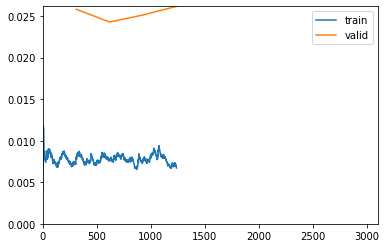

No improvement since epoch 1: early stopping


In [24]:
fname="hrnet-manual-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-7,2e-7),cbs=callbacksFitAfterUnfreeze)

In [22]:
learn.load("hrnet-manual-data-augmentation-after-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.02428402379155159,0.9979251623153687,0.9655400220705883,0.9333759088517137]

In [23]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/hrnet-dataset1-data-augmentation.pth")

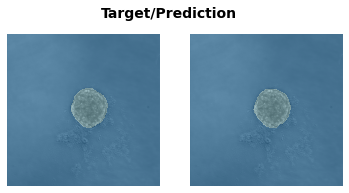

In [27]:
learn.show_results(vmin=0,vmax=1) # show results

## Manual + SpheroidJ Annotations

In [13]:
manual_spheroidj_name = "manual + spheroidj"

In [14]:
path_manual_plus_spheroidj_clear_img = path_images/manual_spheroidj_name
path_manual_plus_spheroidj_clear_lbl = path_labels/manual_spheroidj_name

../datasets/Images/manual + spheroidj/805.png


<AxesSubplot:>

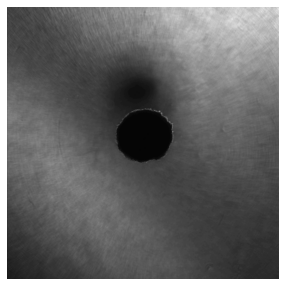

In [15]:
fnames_manual_plus_spheroidj_clear = get_image_files(path_manual_plus_spheroidj_clear_img)
lbl_names_manual_plus_spheroidj_clear = get_image_files(path_manual_plus_spheroidj_clear_lbl)

# open and show image
img_f = fnames_manual_plus_spheroidj_clear[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

../datasets/Labels/manual + spheroidj/805.tif


<AxesSubplot:>

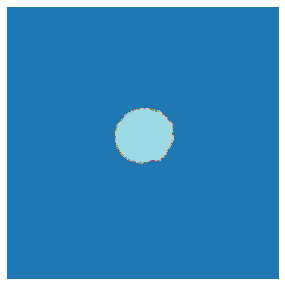

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
print(torch.max(image2tensor(mask)))

tensor(255, dtype=torch.uint8)


In [19]:
size = 1002
bs = 2

### No Data Augmentation

Setting-up type transforms pipelines
Found 1069 items
2 datasets of sizes 963,106
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/42.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 

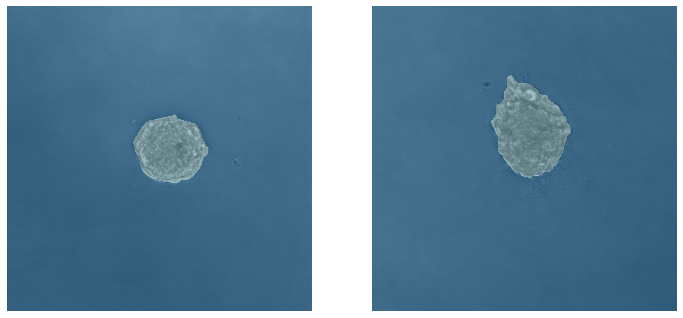

In [20]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_spheroidj_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-4

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-4,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

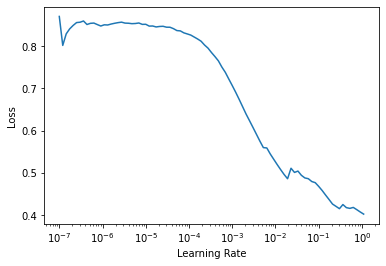

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.026818,0.050872,0.980928,0.918801,0.849799,03:24
1,0.022606,0.032108,0.989130,0.951072,0.906708,03:24
2,0.016239,0.030208,0.989373,0.951697,0.907845,03:25
3,0.014163,0.017532,0.995487,0.966940,0.935995,03:23
4,0.014102,0.013502,0.995960,0.976171,0.953451,03:25
5,0.014560,0.010725,0.997271,0.980553,0.961847,03:25
6,0.011498,0.012958,0.996171,0.975044,0.951304,03:25
7,0.010154,0.010413,0.997471,0.980116,0.961007,03:25
8,0.008600,0.009897,0.997618,0.981454,0.963584,03:25
9,0.007223,0.009919,0.997841,0.981287,0.963261,03:25


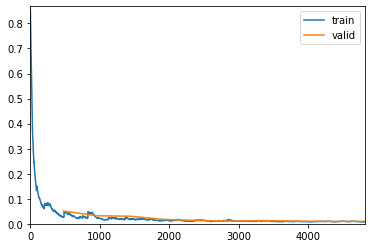

In [23]:
fname="hrnet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-4-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-4-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.009897184558212757,0.9976181387901306,0.9814542019116507,0.9635837718379342]

Recorder

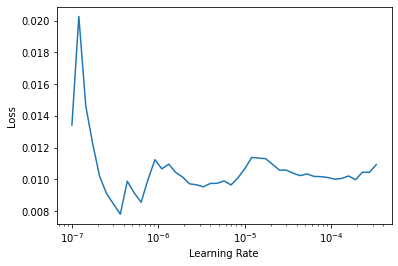

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.007905,0.009926,0.997630,0.981298,0.963283,04:49
1,0.008926,0.009935,0.997819,0.981290,0.963268,04:50
2,0.008155,0.009903,0.997915,0.981394,0.963467,04:50
3,0.008833,0.009808,0.997950,0.981642,0.963945,04:50
4,0.009797,0.009691,0.998000,0.981815,0.964279,04:49
5,0.009056,0.009672,0.998022,0.981856,0.964359,04:49
6,0.008570,0.009696,0.997981,0.981935,0.964511,04:49
7,0.009361,0.009700,0.998002,0.981889,0.964423,04:51


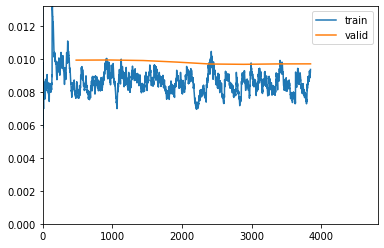

No improvement since epoch 5: early stopping


In [24]:
fname="hrnet-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-4-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-3

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-3,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

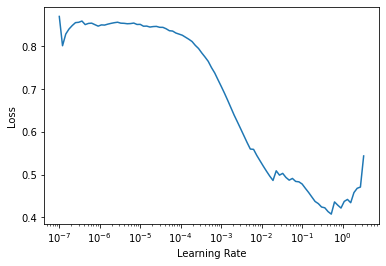

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.026501,0.043726,0.983645,0.927240,0.864350,03:22
1,0.031531,0.072211,0.976700,0.911885,0.838041,03:23
2,0.013186,0.033726,0.992854,0.964159,0.930798,03:23
3,0.026749,0.034966,0.990710,0.948219,0.901536,03:23
4,0.014234,0.016661,0.997227,0.976339,0.953772,03:23
5,0.013326,0.011518,0.996366,0.977001,0.955037,03:23
6,0.012233,0.012496,0.997877,0.976791,0.954635,03:23
7,0.010177,0.011254,0.997877,0.979612,0.960039,03:23
8,0.008608,0.010965,0.997945,0.980280,0.961323,03:23
9,0.007334,0.010961,0.998153,0.980243,0.961252,03:23


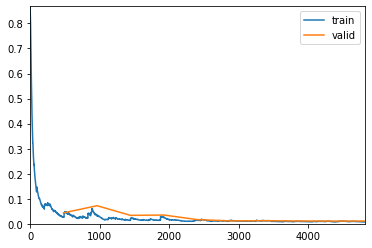

In [23]:
fname="hrnet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-3-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.010960949584841728,0.9981527328491211,0.9802433048711631,0.96125213941088]

Recorder

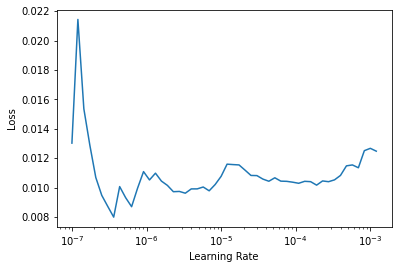

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.007923,0.011712,0.998138,0.979498,0.959820,04:48
1,0.008949,0.010950,0.998149,0.980231,0.961228,04:48
2,0.008177,0.010719,0.998180,0.980397,0.961549,04:48
3,0.009119,0.010825,0.998178,0.980309,0.961378,04:48
4,0.009913,0.010868,0.998172,0.980290,0.961342,04:48


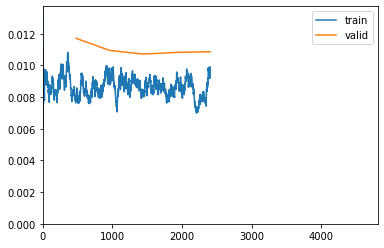

No improvement since epoch 2: early stopping


In [24]:
fname="hrnet-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-3-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-2

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-2,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

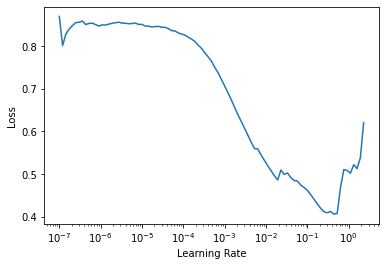

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.026755,0.047264,0.982420,0.923620,0.858080,03:24
1,0.028272,0.038007,0.986819,0.942929,0.892021,03:24
2,0.011972,0.020480,0.995489,0.970388,0.942479,03:24
3,0.015241,0.112189,0.999285,0.839298,0.723095,03:24
4,0.015060,0.042637,0.987197,0.936952,0.881382,03:24


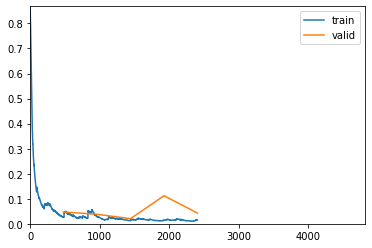

No improvement since epoch 2: early stopping


In [23]:
fname="hrnet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.02048029936850071,0.9954894185066223,0.9703878236606467,0.9424789701989823]

Recorder

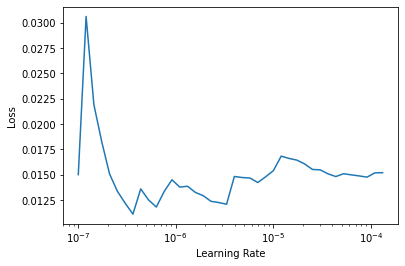

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.011028,0.018701,0.995970,0.969483,0.940773,04:50
1,0.012285,0.016128,0.996381,0.971534,0.944644,04:50
2,0.009880,0.015247,0.997006,0.973201,0.947801,04:50
3,0.012363,0.014994,0.997403,0.974875,0.950982,04:50
4,0.013749,0.015003,0.997730,0.975429,0.952036,04:50
5,0.012268,0.014896,0.997847,0.975993,0.953112,04:51
6,0.013152,0.014613,0.997683,0.975848,0.952835,04:49
7,0.013042,0.015104,0.997807,0.975562,0.952290,04:50
8,0.010991,0.014959,0.997754,0.975820,0.952782,04:51


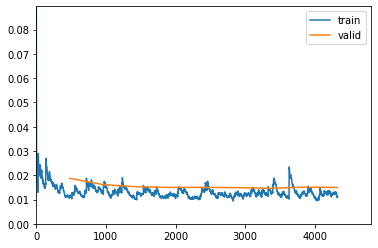

No improvement since epoch 6: early stopping


In [24]:
fname="hrnet-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-1,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.001737800776027143)


Recorder

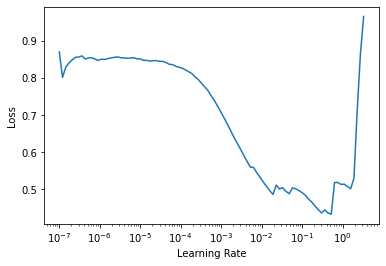

In [22]:
print(learn.lr_find()) # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.027318,0.048324,0.982049,0.922666,0.856434,03:24
1,0.031166,0.059411,0.981693,0.924460,0.859531,03:25
2,0.012896,0.017549,0.995179,0.969977,0.941704,03:25
3,0.016703,0.015321,0.998238,0.974936,0.951098,03:25
4,0.015909,0.013771,0.996278,0.974823,0.950883,03:25
5,0.013471,0.013056,0.997628,0.977344,0.955691,03:25
6,0.013305,0.013254,0.997423,0.975441,0.952059,03:25
7,0.010395,0.010656,0.997068,0.979744,0.960292,03:25
8,0.008744,0.010447,0.997998,0.980350,0.961458,03:25
9,0.007340,0.009915,0.998022,0.980909,0.962533,03:26


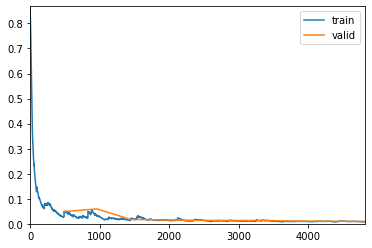

In [23]:
fname="hrnet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.00991537980735302,0.9980219006538391,0.9809087486227601,0.9625327931106478]

Recorder

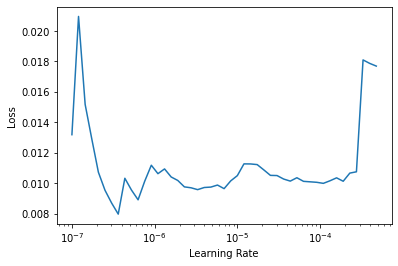

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.007980,0.010189,0.998048,0.980361,0.961479,04:48
1,0.009086,0.010002,0.998070,0.980715,0.962160,04:49
2,0.008227,0.009942,0.998104,0.980775,0.962275,04:47
3,0.008993,0.009924,0.998057,0.980769,0.962264,04:49
4,0.010032,0.010029,0.998089,0.980628,0.961992,04:50
5,0.009190,0.009906,0.998098,0.980821,0.962363,04:49
6,0.009197,0.009706,0.998045,0.981221,0.963134,04:49
7,0.009455,0.009853,0.998069,0.980964,0.962639,04:50
8,0.008352,0.009701,0.998044,0.981272,0.963233,04:49
9,0.007190,0.009758,0.998060,0.981101,0.962903,04:49


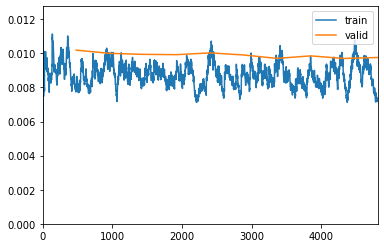

In [24]:
fname="hrnet-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 1435 items
2 datasets of sizes 1069,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255

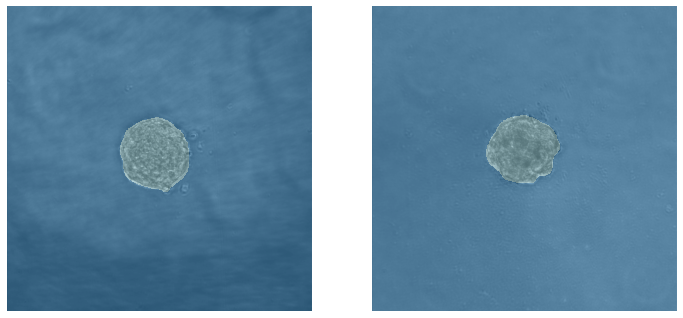

In [20]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                                     get_items=partial(get_image_files,folders=[manual_spheroidj_name,test_name]),
                                     get_y=get_y_fn,
                                     splitter=FuncSplitter(ParentSplitter),
                                     item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                                     batch_tfms=Normalize.from_stats(*imagenet_stats)
                          )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-4,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

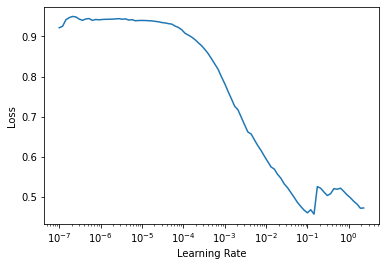

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.039098,0.034148,0.989416,0.941467,0.889408,03:59
1,0.020063,0.035126,0.987612,0.942889,0.891949,03:59
2,0.016467,0.017242,0.994790,0.967414,0.936885,03:59
3,0.013905,0.039738,0.986802,0.940304,0.887333,03:59
4,0.013170,0.017141,0.997338,0.970124,0.941981,04:00
5,0.014972,0.017165,0.994050,0.968666,0.939236,04:00
6,0.009490,0.017278,0.997846,0.970963,0.943565,03:59
7,0.009002,0.014622,0.997161,0.975026,0.951268,04:00
8,0.009756,0.015359,0.997386,0.974483,0.950236,04:00
9,0.009115,0.015416,0.997358,0.974572,0.950404,03:59


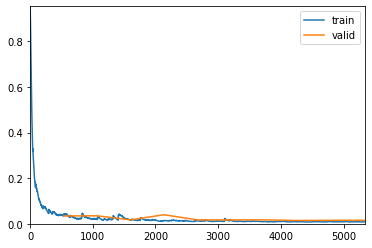

No improvement since epoch 7: early stopping


In [23]:
fname="hrnet-manual-spheroidj-no-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-spheroidj-no-data-augmentation-before-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.014621751382946968,0.9971606135368347,0.9750256500409167,0.9512683415734642]

In [23]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/hrnet-dataset3-no-data-augmentation.pth")

Recorder

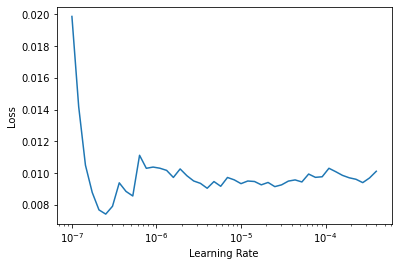

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.009243,0.014823,0.997359,0.974620,0.950497,05:33
1,0.009055,0.015004,0.997328,0.974381,0.950043,05:34
2,0.009041,0.015052,0.997266,0.974426,0.950128,05:34


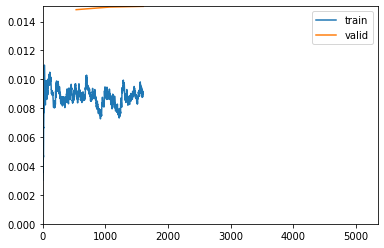

No improvement since epoch 0: early stopping


In [24]:
fname="hrnet-manual-spheroidj-no-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-6,3e-6),cbs=callbacksFitAfterUnfreeze)

In [22]:
learn.load("hrnet-manual-spheroidj-no-data-augmentation-after-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.014823218807578087,0.9973593950271606,0.9746204933616878,0.9504973398161262]

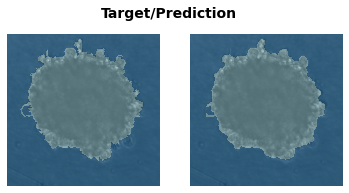

In [27]:
learn.show_results(vmin=0,vmax=1) # show results

### DataAugmentation

Setting-up type transforms pipelines
Found 1069 items
2 datasets of sizes 963,106
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/42.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeli

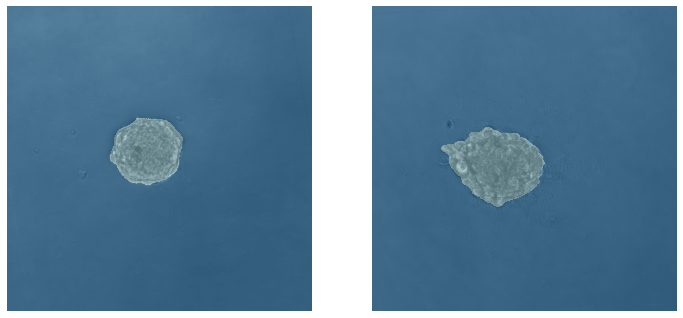

In [20]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_spheroidj_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-4

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-4,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

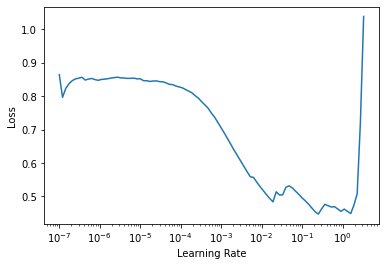

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.028351,0.055006,0.978979,0.912503,0.839086,03:24
1,0.025230,0.037975,0.989858,0.949125,0.903175,03:24
2,0.012967,0.020505,0.992729,0.961092,0.925098,03:25
3,0.020405,0.020300,0.997826,0.962439,0.927598,03:25
4,0.015686,0.011723,0.998148,0.978055,0.957053,03:25
5,0.013604,0.011013,0.998291,0.979029,0.958920,03:25
6,0.012804,0.013447,0.997358,0.974893,0.951015,03:25
7,0.011330,0.011244,0.998020,0.979908,0.960607,03:25


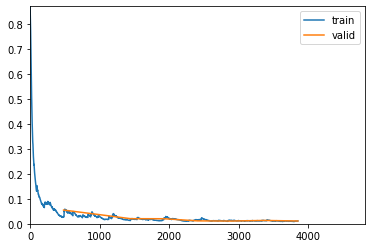

No improvement since epoch 5: early stopping


In [23]:
fname="hrnet-manual-spheroidj-data-augmentation-before-unfreeze-WD-4-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-spheroidj-data-augmentation-before-unfreeze-WD-4-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.011013050563633442,0.9982913732528687,0.9790292732129694,0.9589200233918068]

Recorder

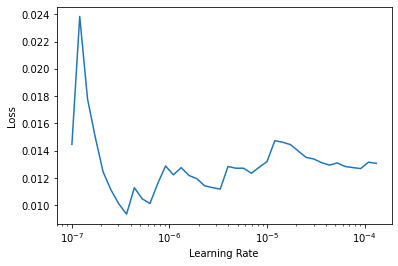

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.009772,0.010626,0.997518,0.980265,0.961293,04:51
1,0.011053,0.010494,0.997970,0.980245,0.961256,04:52
2,0.009528,0.010451,0.998186,0.980112,0.960999,04:52
3,0.010742,0.010493,0.998195,0.979930,0.960650,04:51
4,0.011803,0.010553,0.998227,0.979722,0.960250,04:52


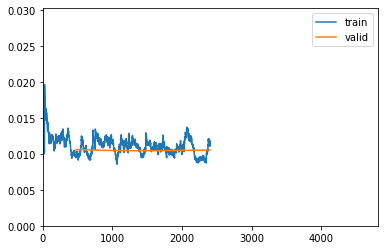

No improvement since epoch 2: early stopping


In [24]:
fname="hrnet-manual-spheroidj-data-augmentation-after-unfreeze-WD-4-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-3

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-3,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

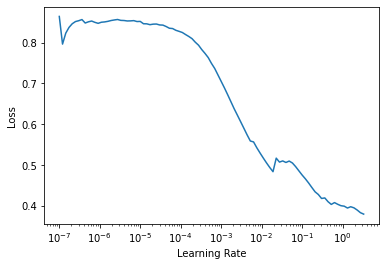

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.028104,0.064567,0.975174,0.899904,0.818023,03:24
1,0.025345,0.031832,0.992226,0.957600,0.918649,03:25
2,0.012154,0.015736,0.995822,0.973304,0.947996,03:24
3,0.025604,0.020972,0.995655,0.963708,0.929959,03:25
4,0.014985,0.019176,0.997614,0.973884,0.949097,03:24


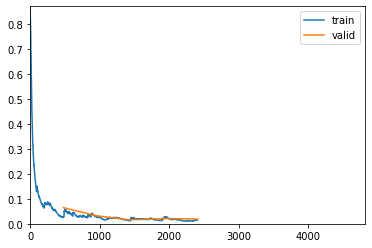

No improvement since epoch 2: early stopping


In [23]:
fname="hrnet-manual-spheroidj-data-augmentation-before-unfreeze-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-spheroidj-data-augmentation-before-unfreeze-WD-3-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.015736009925603867,0.9958217740058899,0.9733040734464085,0.9479964303682312]

Recorder

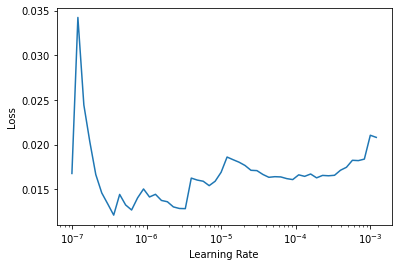

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.011349,0.014961,0.996704,0.973423,0.948222,04:50
1,0.013500,0.012896,0.997131,0.975700,0.952552,04:50
2,0.010439,0.012551,0.997450,0.976234,0.953572,04:51
3,0.013388,0.012097,0.997657,0.977313,0.955632,04:50
4,0.013959,0.012348,0.997907,0.976981,0.954998,04:50
5,0.012821,0.012081,0.997867,0.977378,0.955757,04:49
6,0.014501,0.011980,0.997803,0.977430,0.955857,04:48
7,0.014396,0.012648,0.997893,0.976657,0.954380,04:48
8,0.012942,0.012224,0.997848,0.977024,0.955080,04:48


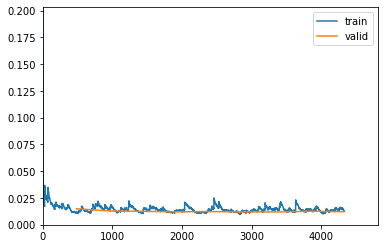

No improvement since epoch 6: early stopping


In [24]:
fname="hrnet-manual-spheroidj-data-augmentation-after-unfreeze-WD-3-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-2

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-2,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

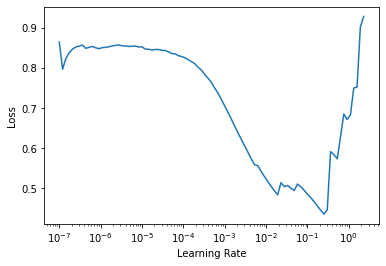

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.028415,0.060498,0.976794,0.905296,0.826977,03:29
1,0.018868,0.016139,0.997635,0.970728,0.943121,03:28
2,0.016909,0.034320,0.987498,0.944949,0.895643,03:29
3,0.014187,0.028231,0.999399,0.952795,0.909846,03:26


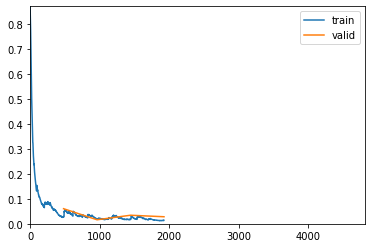

No improvement since epoch 1: early stopping


In [23]:
fname="hrnet-manual-spheroidj-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-spheroidj-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.016139313578605652,0.9976346492767334,0.9707279784012578,0.9431209223908084]

Recorder

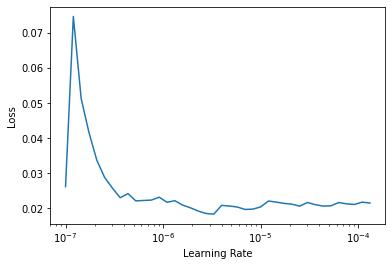

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.013321,0.015533,0.997374,0.970520,0.942728,04:49
1,0.013749,0.014559,0.997460,0.972075,0.945666,04:49
2,0.013177,0.014549,0.997469,0.972086,0.945689,04:49
3,0.015703,0.014243,0.997417,0.972638,0.946733,04:48
4,0.017112,0.014071,0.997506,0.972936,0.947297,04:50
5,0.014988,0.013847,0.997415,0.973383,0.948145,04:50
6,0.015432,0.013793,0.997245,0.973282,0.947955,04:51
7,0.015714,0.013984,0.997397,0.973286,0.947962,04:48
8,0.015229,0.013880,0.997301,0.973324,0.948035,04:48


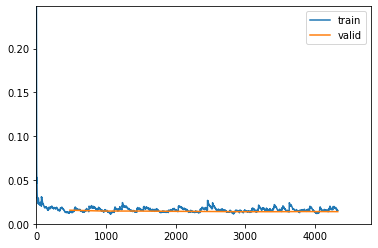

No improvement since epoch 6: early stopping


In [24]:
fname="hrnet-manual-spheroidj-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-1,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

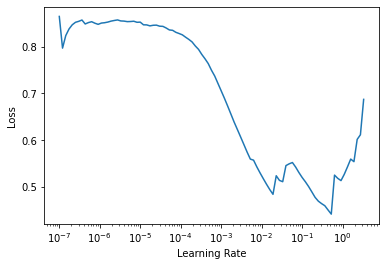

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.028619,0.055771,0.978929,0.910448,0.835616,03:25
1,0.025183,0.023024,0.992556,0.956064,0.915827,03:25
2,0.020478,0.019184,0.994311,0.962954,0.928555,03:25
3,0.015796,0.024609,0.998794,0.953543,0.911210,03:25
4,0.018976,0.015461,0.999161,0.971734,0.945022,03:25
5,0.012240,0.012253,0.997867,0.976577,0.954226,03:25
6,0.012951,0.013624,0.997999,0.973405,0.948189,03:25
7,0.011169,0.010127,0.998266,0.980210,0.961188,03:25
8,0.009624,0.010275,0.998227,0.979950,0.960688,03:25
9,0.007931,0.010309,0.998368,0.979705,0.960216,03:25


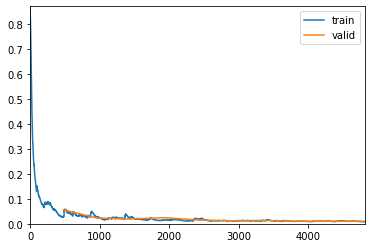

No improvement since epoch 7: early stopping


In [23]:
fname="hrnet-manual-spheroidj-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-spheroidj-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.010126725770533085,0.9982664585113525,0.9802097811335646,0.9611876668351781]

Recorder

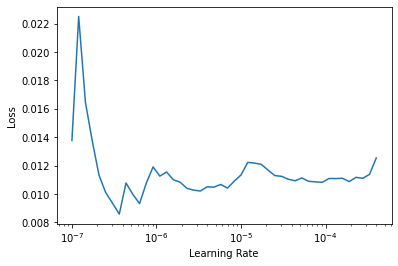

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.008940,0.010329,0.998184,0.979846,0.960489,04:46
1,0.010159,0.010429,0.998315,0.979653,0.960118,04:46
2,0.009072,0.010527,0.998369,0.979356,0.959547,04:46


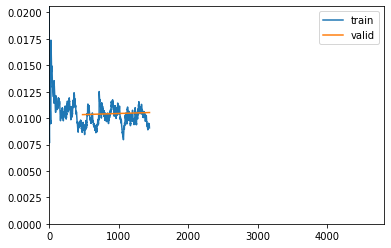

No improvement since epoch 0: early stopping


In [24]:
fname="hrnet-manual-spheroidj-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 1435 items
2 datasets of sizes 1069,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pi

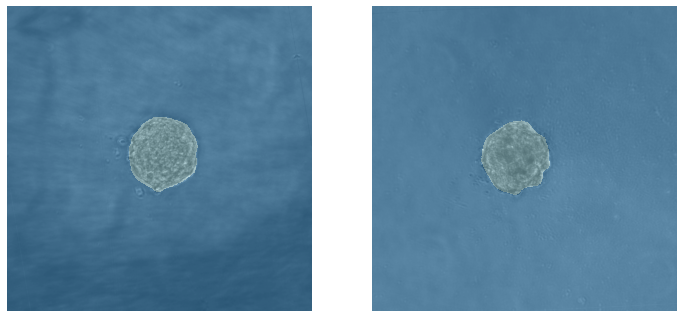

In [20]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_spheroidj_name,test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[tumour, Dice(), JaccardCoeff()], wd=1e-1,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

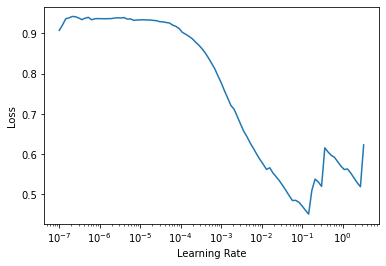

In [22]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.040602,0.032732,0.989426,0.943797,0.893575,03:59
1,0.020838,0.062021,0.984453,0.920129,0.852073,04:02
2,0.016660,0.017993,0.994764,0.968211,0.938381,04:01
3,0.015720,0.023009,0.991454,0.958438,0.920192,04:03
4,0.013810,0.014816,0.997362,0.971785,0.945119,04:02
5,0.013644,0.023700,0.995240,0.959015,0.921257,04:03
6,0.010758,0.015697,0.997406,0.971623,0.944811,04:04


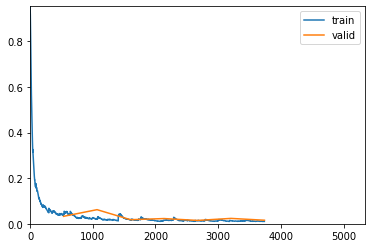

No improvement since epoch 4: early stopping


In [23]:
fname="hrnet-manual-spheroidj-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("hrnet-manual-spheroidj-data-augmentation-before-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.014816404320299625,0.9973618984222412,0.9717853452337288,0.9451191351232301]

Recorder

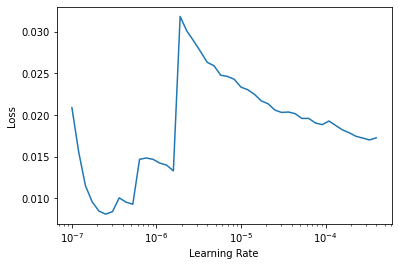

In [23]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.013938,0.015166,0.997511,0.971961,0.945451,05:36
1,0.010927,0.016598,0.997571,0.970991,0.943617,05:36
2,0.010787,0.016218,0.997332,0.972012,0.945548,05:35
3,0.010255,0.014742,0.997029,0.973209,0.947817,05:35
4,0.010100,0.017094,0.996960,0.970040,0.941822,05:33
5,0.009848,0.016046,0.996945,0.971259,0.944124,05:36


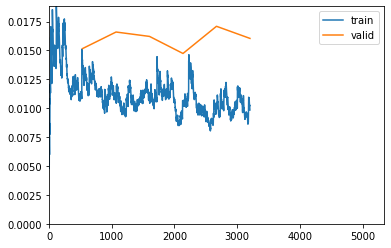

No improvement since epoch 3: early stopping


In [24]:
fname="hrnet-manual-spheroidj-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-6,3e-5),cbs=callbacksFitAfterUnfreeze)

In [22]:
learn.load("hrnet-manual-spheroidj-data-augmentation-after-unfreeze-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.014741519466042519,0.9970291256904602,0.973209418001277,0.9478168528843084]

In [23]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/hrnet-dataset3-data-augmentation.pth")

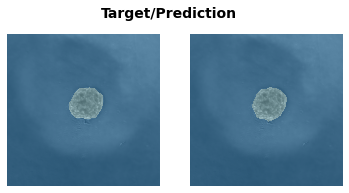

In [23]:
learn.show_results(vmin=0,vmax=1) # show results